In [1]:
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pywt
rand_seed = 114514
np.random.seed(rand_seed)  # 设置随机种子以保证结果可重复



# EMG 手势识别
使用了戴在使用者前臂上的 MYO Thalmic 手镯，以及带有蓝牙接收器的电脑。该手镯配备了8个传感器，均匀分布在前臂周围，同时获取肌电信号。
信号通过蓝牙接口发送到 PC 机

展示了36名受试者在做一系列静态手势时的原始肌电图数据。
受试者表演两个系列，每个系列由六个(七个)基本手势组成。每个手势被执行了3秒钟，手势之间的停顿3秒钟。

每个文件由10列组成:
0 - 未标记数据，
1 - 手部静止，
2 - 手握成拳，
3 - 手腕屈曲，
4 - 手腕伸展，
5 - 桡侧偏移，
6 - 尺侧偏移，
7 - 手掌伸展（并非所有受试者均执行了此手势）。

“label”列，用于表示执行实验的受试者。共有36名受试者，每位受试者各自执行7种手势两次。

data = pd

In [2]:
data = pd.read_csv('./data/EMG-data.csv')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4237907 entries, 0 to 4237906
Data columns (total 11 columns):
 #   Column    Dtype  
---  ------    -----  
 0   time      int64  
 1   channel1  float64
 2   channel2  float64
 3   channel3  float64
 4   channel4  float64
 5   channel5  float64
 6   channel6  float64
 7   channel7  float64
 8   channel8  float64
 9   class     int64  
 10  label     int64  
dtypes: float64(8), int64(3)
memory usage: 355.7 MB


In [3]:
print(data['class'].value_counts())

class
0    2725157
6     253009
5     251733
4     251570
1     250055
3     249494
2     243193
7      13696
Name: count, dtype: int64


由于0类别太多了，并且没有实际意义，剩余的数据分布相对合适
同时类别7的数据也太少了，为了排除干扰，直接删去

In [4]:
data.drop(data[data['class'] == 0].index, inplace=True)
data.drop(data[data['class'] == 7].index, inplace=True)
print(data['class'].value_counts())
print(data['class'].value_counts().sum())

class
6    253009
5    251733
4    251570
1    250055
3    249494
2    243193
Name: count, dtype: int64
1499054


In [5]:
# save
data.to_csv('./data/EMG-data-sub.csv', index=False)


数据以毫秒帧为单位存储，为了能获取肌电的时序性特征，需要将相邻的样本合并成同一样本

In [6]:
from tqdm import tqdm
def assign_sample_ids(df, time_col='time', label_col='label', class_col='class', min_length=3):
    # Create a new column for sample_id
    df['sample_id'] = 0
    sample_id = 1
    
    # Initialize the first sample_id
    df.iloc[0, df.columns.get_loc('sample_id')] = sample_id
    
    # Vectorized way to determine where new samples start
    mask = (df[time_col].diff() <= 0) | (df[label_col].diff() != 0) | (df[class_col].diff() != 0)
    df.loc[mask, 'sample_id'] = 1
    df['sample_id'] = df['sample_id'].cumsum()
    
    # Determine the length of each sequence
    sequence_lengths = df.groupby('sample_id').size()
    
    # Identify short sequences
    short_sequences = sequence_lengths[sequence_lengths < min_length].to_dict()
    
    # Print short sequences
    for seq_id, length in short_sequences.items():
        print(f"Sequence ID: {seq_id}, Length: {length}")
    
    return df, list(short_sequences.keys())

data,sot_sq = assign_sample_ids(data, time_col='time', label_col='label', class_col='class', min_length=100)
print(data.info())
 


<class 'pandas.core.frame.DataFrame'>
Index: 1499054 entries, 2287 to 4237211
Data columns (total 12 columns):
 #   Column     Non-Null Count    Dtype  
---  ------     --------------    -----  
 0   time       1499054 non-null  int64  
 1   channel1   1499054 non-null  float64
 2   channel2   1499054 non-null  float64
 3   channel3   1499054 non-null  float64
 4   channel4   1499054 non-null  float64
 5   channel5   1499054 non-null  float64
 6   channel6   1499054 non-null  float64
 7   channel7   1499054 non-null  float64
 8   channel8   1499054 non-null  float64
 9   class      1499054 non-null  int64  
 10  label      1499054 non-null  int64  
 11  sample_id  1499054 non-null  int64  
dtypes: float64(8), int64(4)
memory usage: 148.7 MB
None


In [7]:
# save
data.to_csv('./data/EMG-data-sub-sample.csv', index=False)


In [8]:
# Load the data
data = pd.read_csv('./data/EMG-data-sub-sample.csv')

In [9]:
print(data.head())

   time  channel1  channel2  channel3  channel4  channel5  channel6  channel7  \
0  2400  -0.00001   0.00000  -0.00001   0.00000   0.00000  -0.00001  -0.00001   
1  2401  -0.00001  -0.00002   0.00000  -0.00001  -0.00001  -0.00001  -0.00003   
2  2402  -0.00001  -0.00002   0.00000  -0.00001  -0.00001  -0.00001  -0.00003   
3  2403  -0.00001  -0.00002   0.00000  -0.00001  -0.00001  -0.00001  -0.00003   
4  2404  -0.00001  -0.00002   0.00000  -0.00001  -0.00001  -0.00001  -0.00003   

   channel8  class  label  sample_id  
0   0.00001      1      1          1  
1  -0.00002      1      1          1  
2  -0.00002      1      1          1  
3  -0.00002      1      1          1  
4  -0.00002      1      1          1  


   time  channel1  channel2  channel3  channel4  channel5  channel6  channel7  \
0  2400  -0.00001   0.00000  -0.00001   0.00000   0.00000  -0.00001  -0.00001   
1  2401  -0.00001  -0.00002   0.00000  -0.00001  -0.00001  -0.00001  -0.00003   
2  2402  -0.00001  -0.00002   0.00000  -0.00001  -0.00001  -0.00001  -0.00003   
3  2403  -0.00001  -0.00002   0.00000  -0.00001  -0.00001  -0.00001  -0.00003   
4  2404  -0.00001  -0.00002   0.00000  -0.00001  -0.00001  -0.00001  -0.00003   

   channel8  class  label  sample_id  
0   0.00001      1      1          1  
1  -0.00002      1      1          1  
2  -0.00002      1      1          1  
3  -0.00002      1      1          1  
4  -0.00002      1      1          1  
Average Length: 1735.0162037037037
Max Length: 4280
Min Length: 1052
Length Variance: 86499.48525277885
Number of Groups: 864


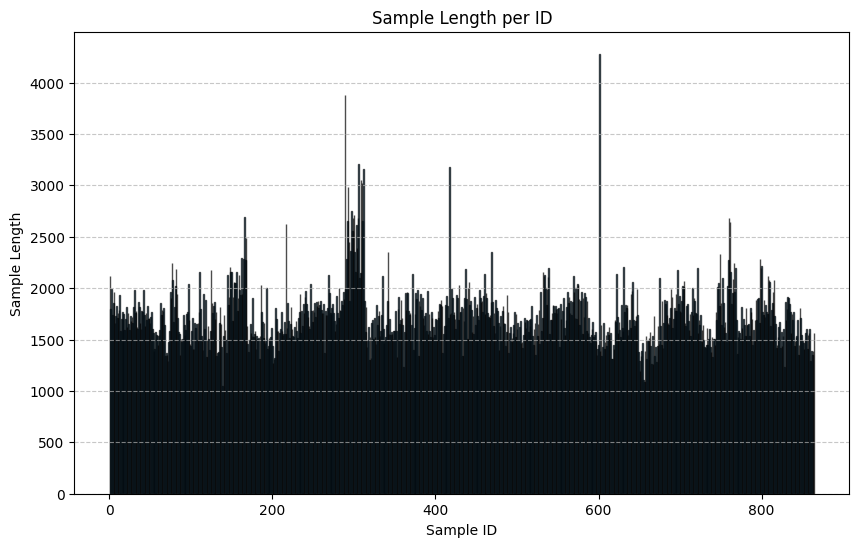

In [9]:

# 按照 sample_id 列进行分组
data_grouped_id = data.groupby('sample_id')

# 获取 sample_id 为 1 的所有行
id_1_data = data_grouped_id.get_group(1)

# 打印 sample_id 为 1 的前几行
print(id_1_data.head())

# 获取每个组的长度
grouped_lengths = data_grouped_id.size()

# 计算统计信息
avg_length = grouped_lengths.mean()
max_length = grouped_lengths.max()
min_length = grouped_lengths.min()
length_var = grouped_lengths.var()
num_groups = grouped_lengths.count()

# 打印统计信息
print(f"Average Length: {avg_length}")
print(f"Max Length: {max_length}")
print(f"Min Length: {min_length}")
print(f"Length Variance: {length_var}")
print(f"Number of Groups: {num_groups}")

# 绘制分布图
plt.figure(figsize=(10, 6))
plt.bar(grouped_lengths.index, grouped_lengths, alpha=0.7, edgecolor='black')

plt.title('Sample Length per ID')
plt.xlabel('Sample ID')
plt.ylabel('Sample Length')
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.show()

plt.show()

检查一下频域

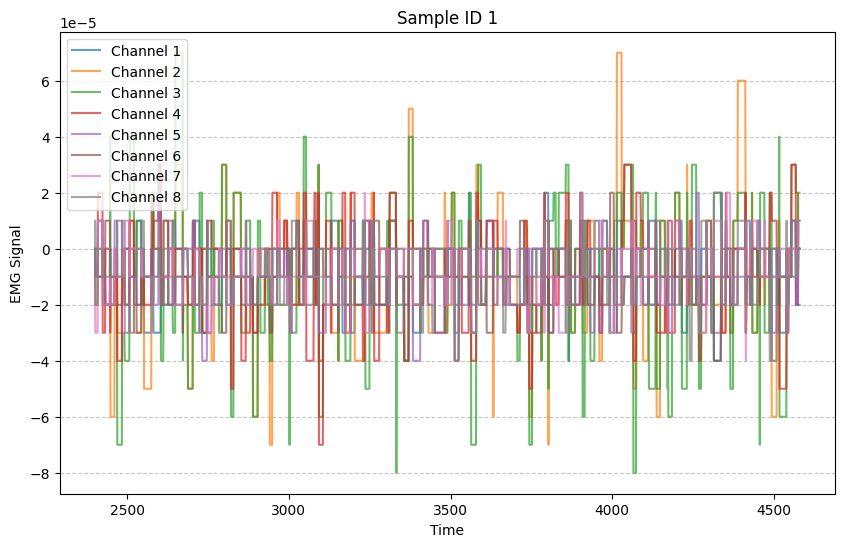

In [10]:
# plt id_1_data
plt.figure(figsize=(10, 6))
plt.plot(id_1_data['time'], id_1_data['channel1'], label='Channel 1', alpha=0.7)
plt.plot(id_1_data['time'], id_1_data['channel2'], label='Channel 2', alpha=0.7)
plt.plot(id_1_data['time'], id_1_data['channel3'], label='Channel 3', alpha=0.7)
plt.plot(id_1_data['time'], id_1_data['channel4'], label='Channel 4', alpha=0.7)
plt.plot(id_1_data['time'], id_1_data['channel5'], label='Channel 5', alpha=0.7)
plt.plot(id_1_data['time'], id_1_data['channel6'], label='Channel 6', alpha=0.7)
plt.plot(id_1_data['time'], id_1_data['channel7'], label='Channel 7', alpha=0.7)
plt.plot(id_1_data['time'], id_1_data['channel8'], label='Channel 8', alpha=0.7)

plt.title('Sample ID 1')
plt.xlabel('Time')
plt.ylabel('EMG Signal')
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# fft

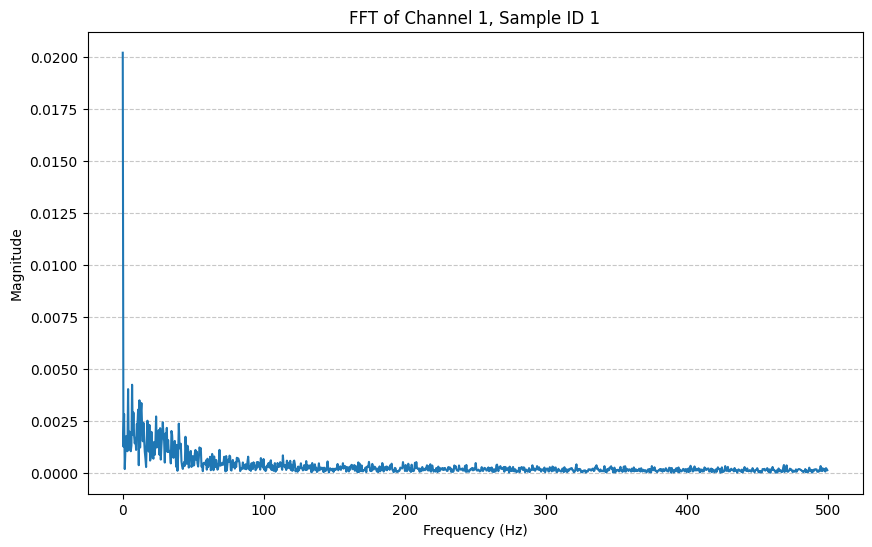

In [11]:
fs = 1000 # 1ms
fft_values = np.fft.fft(id_1_data['channel1'])
fft_freeqs = np.fft.fftfreq(len(fft_values), 1/fs)

positive_freqs = fft_freeqs[:len(fft_freeqs)//2]
positive_fft_values = np.abs(fft_values)[:len(fft_values)//2]

plt.figure(figsize=(10, 6))
plt.plot(positive_freqs, positive_fft_values)
plt.title('FFT of Channel 1, Sample ID 1')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Magnitude')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()



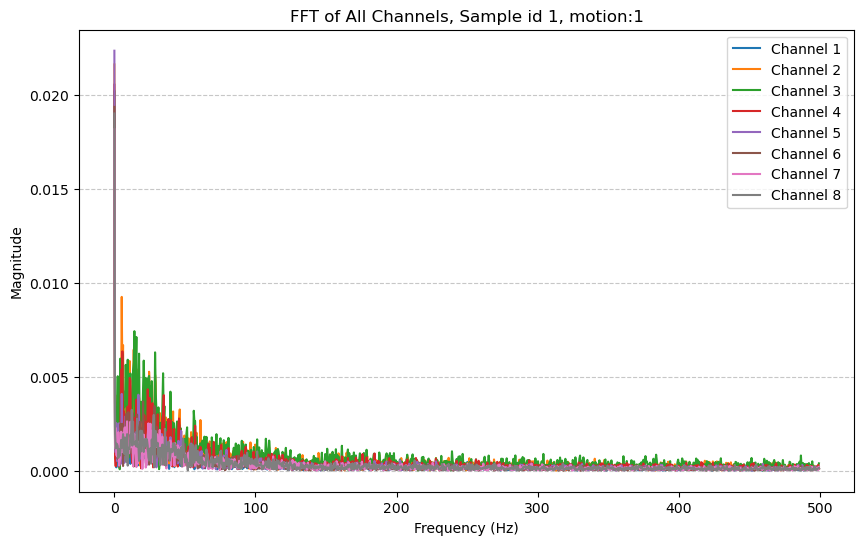

In [13]:
# other channel, all in one

fft_channle1 = np.fft.fft(id_1_data['channel1'])
fft_channle2 = np.fft.fft(id_1_data['channel2'])
fft_channle3 = np.fft.fft(id_1_data['channel3'])
fft_channle4 = np.fft.fft(id_1_data['channel4'])
fft_channle5 = np.fft.fft(id_1_data['channel5'])
fft_channle6 = np.fft.fft(id_1_data['channel6'])
fft_channle7 = np.fft.fft(id_1_data['channel7'])
fft_channle8 = np.fft.fft(id_1_data['channel8'])

positive_fft_values1 = np.abs(fft_channle1)[:len(fft_channle1)//2]
positive_fft_values2 = np.abs(fft_channle2)[:len(fft_channle2)//2]
positive_fft_values3 = np.abs(fft_channle3)[:len(fft_channle3)//2]
positive_fft_values4 = np.abs(fft_channle4)[:len(fft_channle4)//2]
positive_fft_values5 = np.abs(fft_channle5)[:len(fft_channle5)//2]
positive_fft_values6 = np.abs(fft_channle6)[:len(fft_channle6)//2]
positive_fft_values7 = np.abs(fft_channle7)[:len(fft_channle7)//2]
positive_fft_values8 = np.abs(fft_channle8)[:len(fft_channle8)//2]

plt.figure(figsize=(10, 6))
plt.plot(positive_freqs, positive_fft_values1, label='Channel 1')
plt.plot(positive_freqs, positive_fft_values2, label='Channel 2')
plt.plot(positive_freqs, positive_fft_values3, label='Channel 3')
plt.plot(positive_freqs, positive_fft_values4, label='Channel 4')
plt.plot(positive_freqs, positive_fft_values5, label='Channel 5')
plt.plot(positive_freqs, positive_fft_values6, label='Channel 6')
plt.plot(positive_freqs, positive_fft_values7, label='Channel 7')
plt.plot(positive_freqs, positive_fft_values8, label='Channel 8')

plt.title('FFT of All Channels, Sample id 1, motion:{}'.format(id_1_data['class'].values[0]))
plt.xlabel('Frequency (Hz)')

plt.ylabel('Magnitude')
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


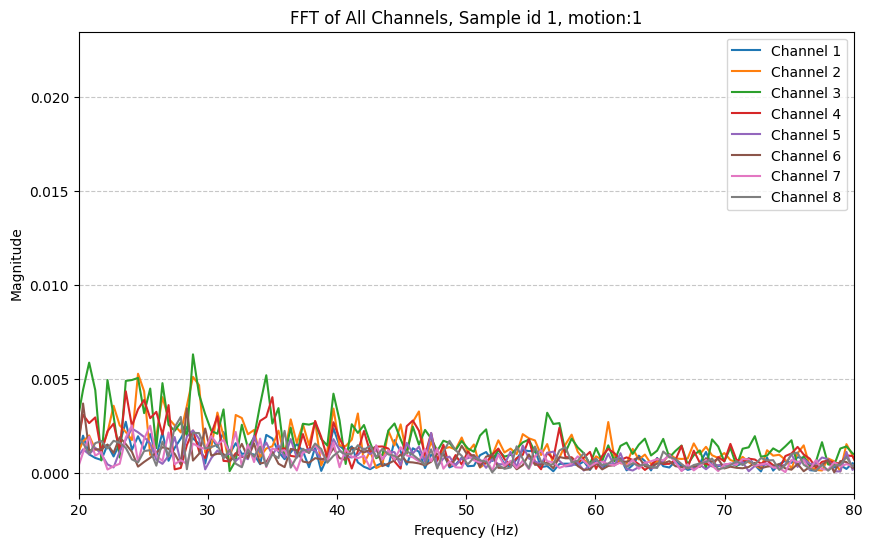

In [12]:
# other channel, all in one

fft_channle1 = np.fft.fft(id_1_data['channel1'])
fft_channle2 = np.fft.fft(id_1_data['channel2'])
fft_channle3 = np.fft.fft(id_1_data['channel3'])
fft_channle4 = np.fft.fft(id_1_data['channel4'])
fft_channle5 = np.fft.fft(id_1_data['channel5'])
fft_channle6 = np.fft.fft(id_1_data['channel6'])
fft_channle7 = np.fft.fft(id_1_data['channel7'])
fft_channle8 = np.fft.fft(id_1_data['channel8'])

positive_fft_values1 = np.abs(fft_channle1)[:len(fft_channle1)//2]
positive_fft_values2 = np.abs(fft_channle2)[:len(fft_channle2)//2]
positive_fft_values3 = np.abs(fft_channle3)[:len(fft_channle3)//2]
positive_fft_values4 = np.abs(fft_channle4)[:len(fft_channle4)//2]
positive_fft_values5 = np.abs(fft_channle5)[:len(fft_channle5)//2]
positive_fft_values6 = np.abs(fft_channle6)[:len(fft_channle6)//2]
positive_fft_values7 = np.abs(fft_channle7)[:len(fft_channle7)//2]
positive_fft_values8 = np.abs(fft_channle8)[:len(fft_channle8)//2]

plt.figure(figsize=(10, 6))
plt.plot(positive_freqs, positive_fft_values1, label='Channel 1')
plt.plot(positive_freqs, positive_fft_values2, label='Channel 2')
plt.plot(positive_freqs, positive_fft_values3, label='Channel 3')
plt.plot(positive_freqs, positive_fft_values4, label='Channel 4')
plt.plot(positive_freqs, positive_fft_values5, label='Channel 5')
plt.plot(positive_freqs, positive_fft_values6, label='Channel 6')
plt.plot(positive_freqs, positive_fft_values7, label='Channel 7')
plt.plot(positive_freqs, positive_fft_values8, label='Channel 8')

plt.title('FFT of All Channels, Sample id 1, motion:{}'.format(id_1_data['class'].values[0]))
plt.xlabel('Frequency (Hz)')
plt.xlim(20,80)
plt.ylabel('Magnitude')
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


看到50HZ并无工频噪声，可以认为数据已经经过了必要的预处理

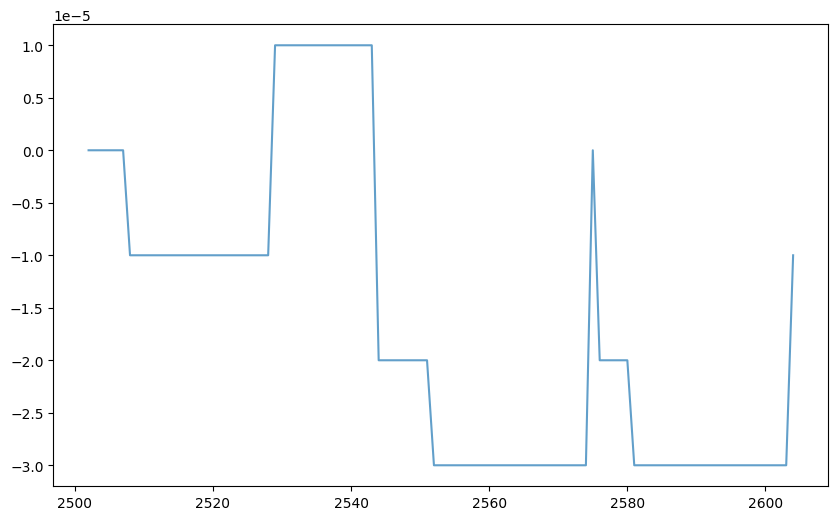

In [13]:
plt.figure(figsize=(10, 6))
plt.plot(id_1_data['time'][100:200], id_1_data['channel1'][100:200], label='Channel 1', alpha=0.7)
plt.show()

# 数据预处理，归一化

In [14]:
mean_channel1 = id_1_data['channel1'].mean()
std_channel1 = id_1_data['channel1'].std()
print(f"Mean: {mean_channel1}, Standard Deviation: {std_channel1}")

Mean: -9.560283687943264e-06, Standard Deviation: 1.248065795556002e-05


(1499054, 12)
(19655, 1024, 8) (19655,)


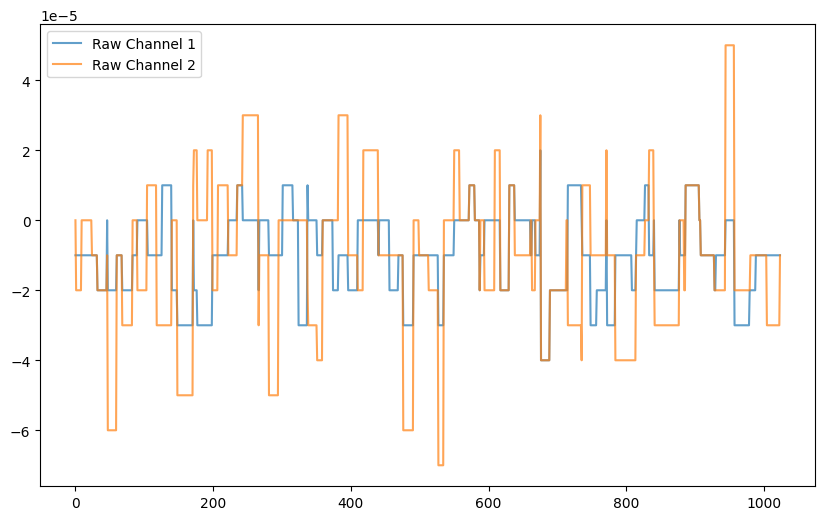

In [15]:
def sliding_window(data, window_size, stride):
    print(data.shape)
    windowed_data = []
    labels = []

    for sample_id, group in data.groupby('sample_id'):
        for i in range(0, len(group) - window_size + 1, stride):
            windowed = group.iloc[i:i+window_size, :-1][['channel1', 'channel2', 'channel3', 'channel4', 'channel5', 'channel6', 'channel7', 'channel8']].values
            label = group.iloc[i+window_size-1]['class']  
            windowed_data.append(windowed)
            labels.append(label)

    return np.array(windowed_data), np.array(labels)

def normalized(data):
    min_value = np.min(data, axis=(1, 2), keepdims=True)
    max_value = np.max(data, axis=(1, 2), keepdims=True)
    normalized_data = (data - min_value) / (max_value - min_value)
    return normalized_data

# plt 一个窗口的数据




windowed_data, labels = sliding_window(data, window_size=1024, stride=32)
print(windowed_data.shape, labels.shape)
plt.figure(figsize=(10, 6))
plt.plot(windowed_data[0, :, 0], label='Raw Channel 1', alpha=0.7)
plt.plot(windowed_data[0, :, 1], label='Raw Channel 2', alpha=0.7)
plt.legend()
plt.show()


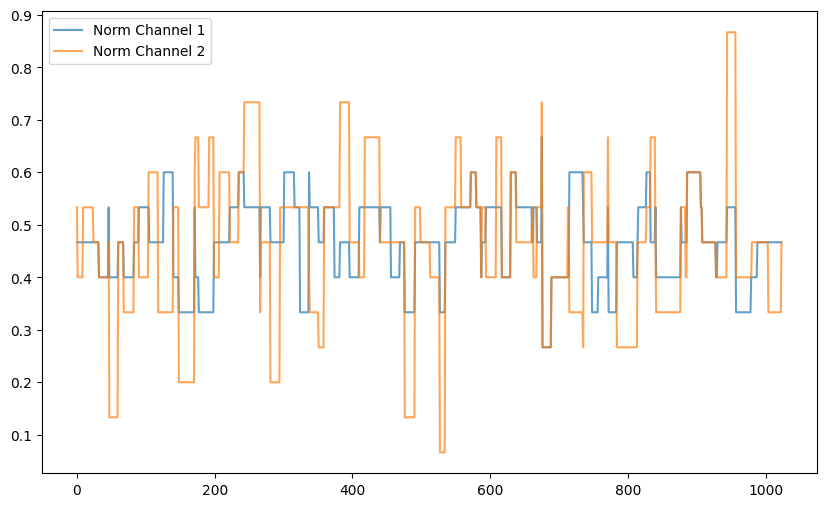

(array([0., 1., 2., 3., 4., 5.]), array([3281, 3071, 3272, 3322, 3336, 3373]))


In [16]:
X = normalized(windowed_data)
plt.figure(figsize=(10, 6))

plt.plot(X[0, :, 0], label='Norm Channel 1', alpha=0.7)
plt.plot(X[0, :, 1], label='Norm Channel 2', alpha=0.7)
plt.legend()
plt.show()
y = labels -1
# check the分布 of y
print(np.unique(y, return_counts=True))


In [18]:
# save the data and label to npy
np.save('./data_processed/X.npy', X) # (43847, 128, 8)
np.save('./data_processed/y.npy', y) # (43847,)

# 小波变换
使用小波变换将时序信号转为二维时频谱
交给cnn进行分类！

In [3]:
import pywt
def wavelet_transform(signal, scales, wavelet='cmor', sampling_period=1/1000):
    coefficients, _ = pywt.cwt(signal, scales, wavelet, sampling_period=sampling_period)
    return coefficients



全部数据太大了，全部缓存要49GB，因此只取一个1000样本的子集试一下


In [4]:
X_sub = np.load('./data_processed/X.npy')
y_sub = np.load('./data_processed/y.npy')

subset_size = 1000

indices = np.random.choice(range(len(X_sub)), size=subset_size, replace=False)

X_sub = X_sub[indices]
y_sub = y_sub[indices]

print(X_sub.shape, y_sub.shape)
print(np.unique(y_sub, return_counts=True))

(1000, 1024, 8) (1000,)
(array([0., 1., 2., 3., 4., 5.]), array([193, 158, 166, 161, 157, 165]))


In [5]:
from tqdm import tqdm
num_samples,num_length,num_channel = X_sub.shape
scales = range(1, 129)
X_wavelet = np.zeros((X_sub.shape[0], X_sub.shape[2], 128, 1024))

# 对每个样本的每个通道进行小波变换
for i in tqdm(range(num_samples),desc='applying wavelet transform'):
    for j in range(num_channel):
        signal = X_sub[i, :, j]
        X_wavelet[i, j, :, :] = np.abs(wavelet_transform(signal, scales))

print(X_wavelet.shape)

applying wavelet transform:   0%|          | 0/1000 [00:00<?, ?it/s]/root/miniconda3/lib/python3.8/site-packages/pywt/_cwt.py:117: FutureWarning: Wavelets from the family cmor, without parameters specified in the name are deprecated. The name should takethe form cmorB-C where B and C are floats representing the bandwidth frequency and center frequency, respectively (example: cmor1.5-1.0).
  wavelet = DiscreteContinuousWavelet(wavelet)
applying wavelet transform: 100%|██████████| 1000/1000 [05:19<00:00,  3.13it/s]

(1000, 8, 128, 1024)


看看小波后的样本

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


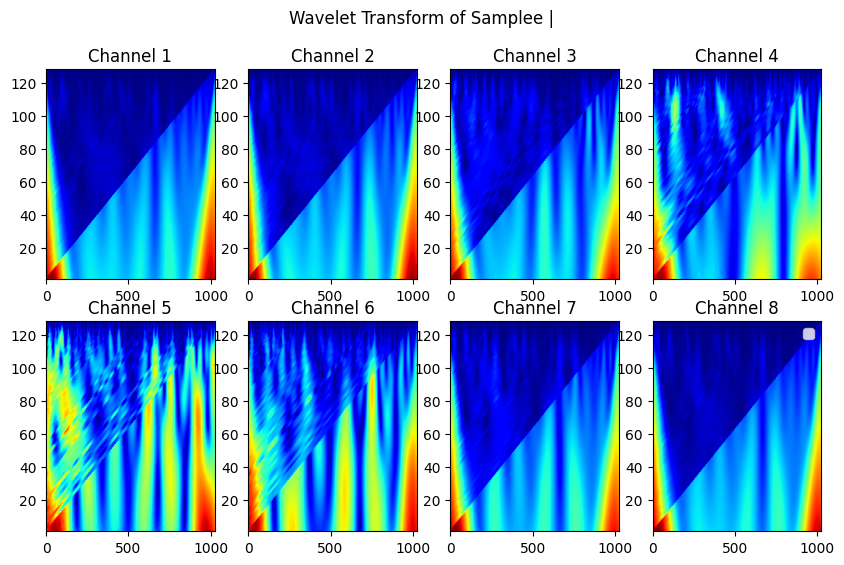

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


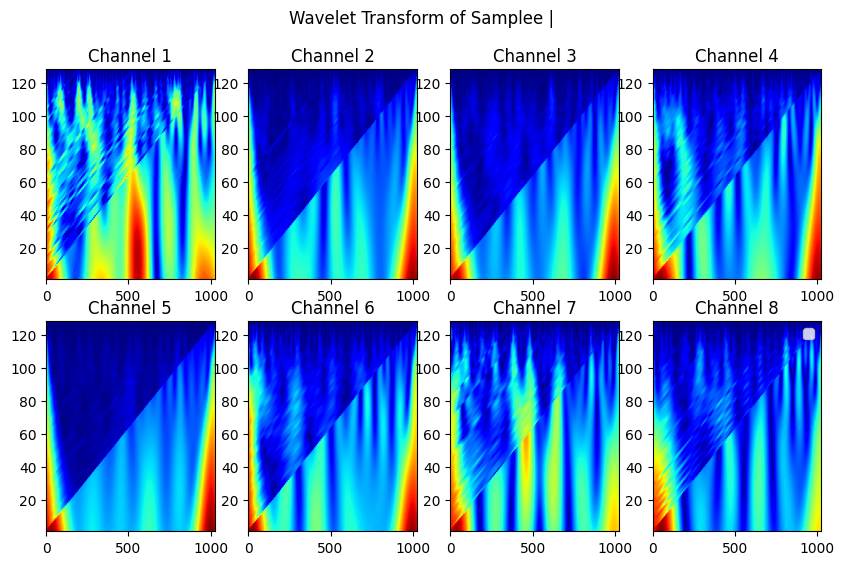

In [5]:
sample_wavelet400 = X_wavelet[149]
sample_wavelet100 = X_wavelet[100]
def view_8_channel_wavelet(data,info=''):
    plt.figure(figsize=(10, 6))
    for i in range(8):
        plt.subplot(2, 4, i+1)
        # plt.imshow(data[i], aspect='auto', cmap='BrBG')
        plt.imshow(data[i], extent=[0, 1024, 1, 128], cmap='jet', aspect='auto', vmax=np.max(data[i]), vmin=np.min(data[i]))

        plt.title(f'Channel {i+1}')

    plt.suptitle('Wavelet Transform of Samplee {}'.format('|'+info))
    plt.legend()
    plt.show()
# plot 8 channel wavelet
view_8_channel_wavelet(sample_wavelet100)
view_8_channel_wavelet(sample_wavelet400)

看看每一个类别的肌电信号的尺度图


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


(6, 8, 128, 1024) (6,)


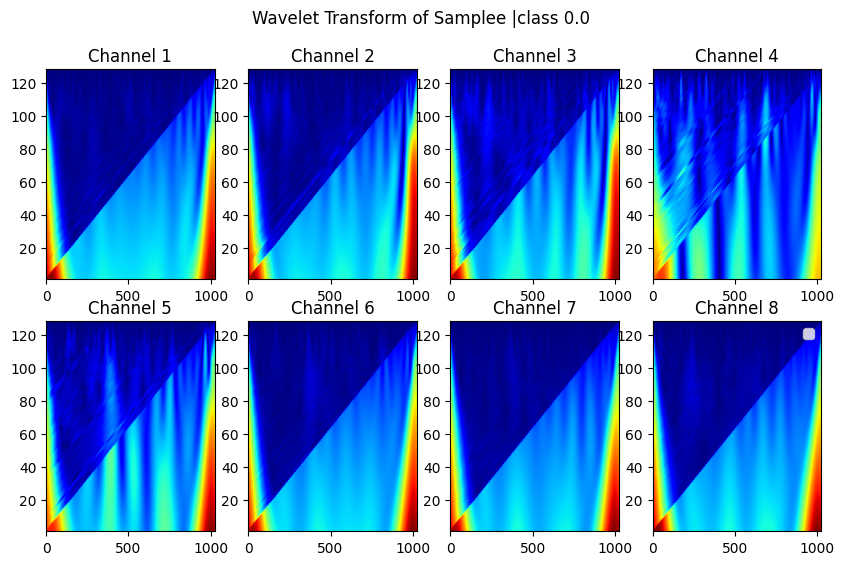

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


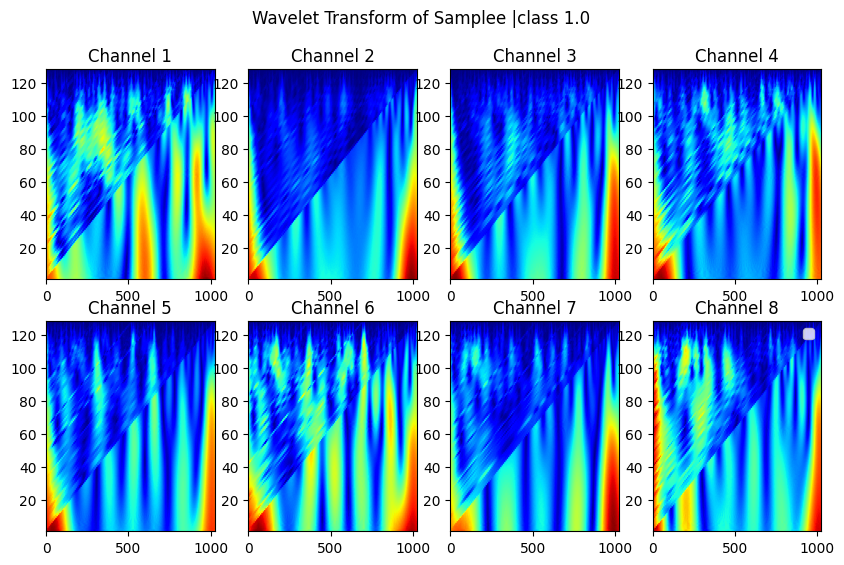

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


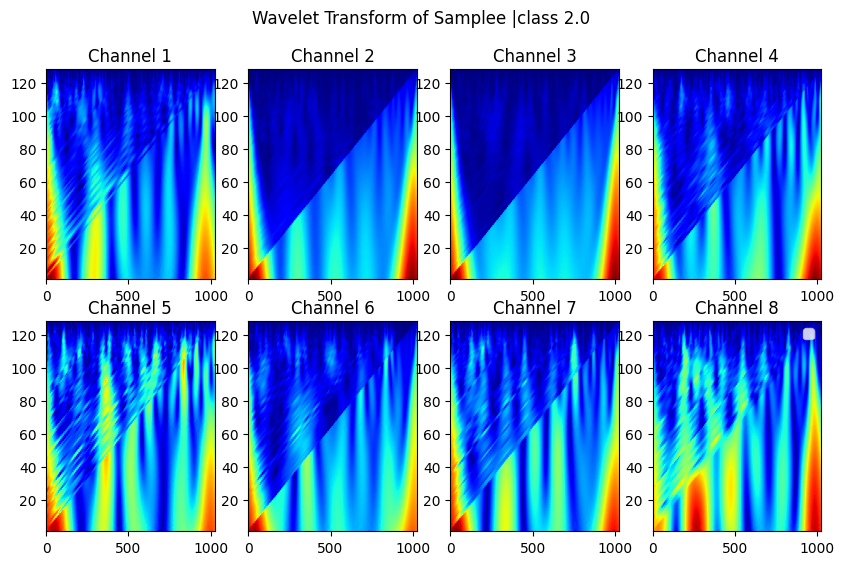

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


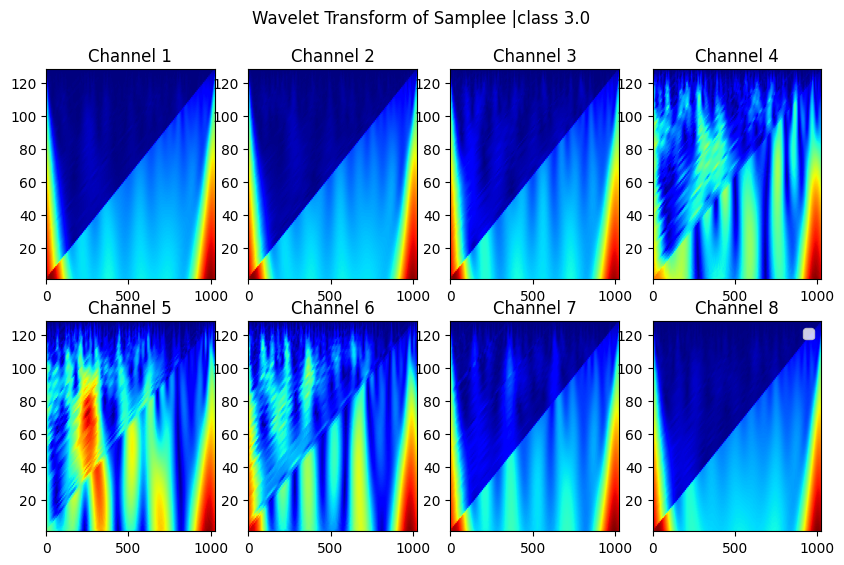

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


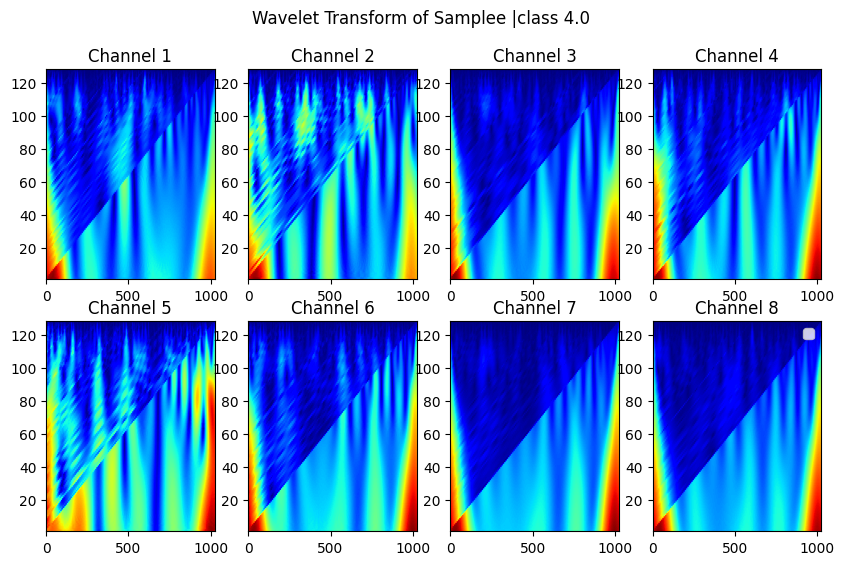

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


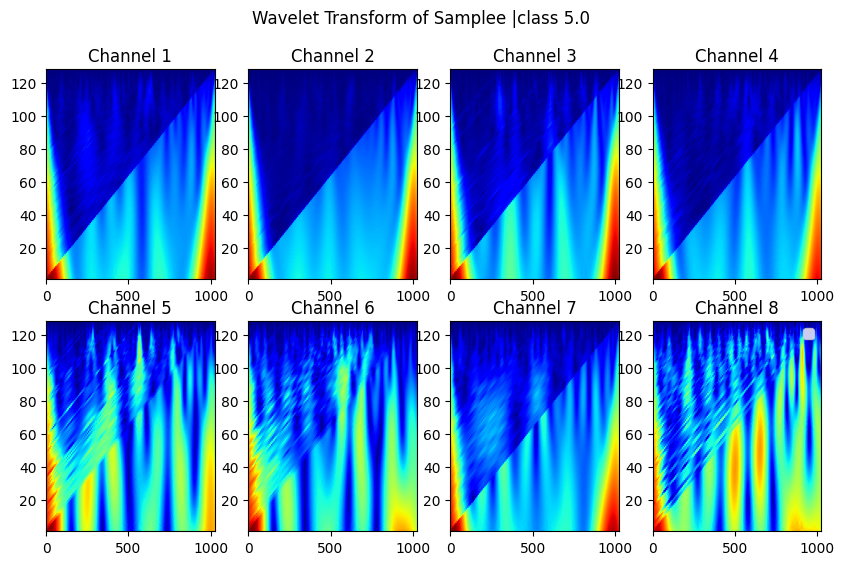

In [6]:
labels = np.unique(y_sub)  # 获取y_sub中所有唯一的标签
selected_indices = []

# 对每个标签随机选择一个样本
for label in labels:
    # 找到当前标签的所有索引
    label_indices = np.where(y_sub == label)[0]
    # 如果存在这样的标签索引，则随机选择一个
    if label_indices.size > 0:
        selected_index = np.random.choice(label_indices)
        selected_indices.append(selected_index)

# 根据选定的索引提取X和Y的子集
X_selected = X_wavelet[selected_indices]
y_selected = y_sub[selected_indices]


# plt every class
print(X_selected.shape, y_selected.shape)
for idx in range(len(X_selected)):
    view_8_channel_wavelet(X_selected[idx],'class '+str(y_selected[idx]))

# 模型的输入输出
我们现在已经可以将时序信号转换为小波频谱，可以使用cnn对时频图像进行识别，分类。
输入：8个通道，每个通道1024*128
输出：one hot编码的0~5 共6类

首先，为了能够加快运行，将测试集和训练集均提前计算为频谱图并保存。

In [6]:
np.save('./data_processed/X_sub1000_wavelet.npy', X_wavelet)
np.save('./data_processed/y_sub1000_wavelet.npy', y_sub)

In [2]:
X_ = np.load('./data_processed/X_sub1000_wavelet.npy')
Y_ = np.load('./data_processed/y_sub1000_wavelet.npy')

In [5]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
print(X_.shape, Y_.shape)

encoder = OneHotEncoder(sparse=False)
Y_ = Y_.reshape(-1, 1)
Y_ = encoder.fit_transform(Y_)
X_train, X_test, y_train, y_test = train_test_split(X_, Y_, test_size=0.2, random_state=rand_seed)





# save to npy
np.save('./data_processed/X_train_sub1000.npy', X_train)
np.save('./data_processed/y_train_sub1000.npy', y_train)
np.save('./data_processed/X_test_sub1000.npy', X_test)
np.save('./data_processed/y_test_sub1000.npy', y_test)

(1000, 8, 128, 1024) (1000,)


/root/miniconda3/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [9]:
# one-hot
print(y_train[1])
test_decode = encoder.inverse_transform([y_train[1]])
print(test_decode)

[0. 0. 0. 0. 1. 0.]
[[4.]]


In [4]:
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)
# check fenbu
print(np.unique(y_train, return_counts=True))
print(np.unique(y_test, return_counts=True))


(800, 8, 128, 1024) (800,)
(200, 8, 128, 1024) (200,)
(array([0., 1., 2., 3., 4., 5.]), array([156, 130, 131, 128, 122, 133]))
(array([0., 1., 2., 3., 4., 5.]), array([37, 28, 35, 33, 35, 32]))


定义模型

In [10]:
import torch.nn as nn
import torch.nn.functional as F

class EMGClassifier(nn.Module):
    def __init__(self):
        super(EMGClassifier, self).__init__()
        # 卷积层
        self.conv1 = nn.Conv2d(8, 16, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(64, 128, kernel_size=3, padding=1)

        # 自适应池化层
        self.adaptive_pool = nn.AdaptiveAvgPool2d((1, 8))

        # 全连接层
        self.fc1 = nn.Linear(128 * 8, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 6)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = self.pool(F.relu(self.conv4(x)))
        x = self.adaptive_pool(x)
        x = torch.flatten(x, 1)  # 展平操作
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.softmax(self.fc3(x), dim=1)
        return x
model = EMGClassifier()
print(model)

EMGClassifier(
  (conv1): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (adaptive_pool): AdaptiveAvgPool2d(output_size=(1, 8))
  (fc1): Linear(in_features=1024, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=6, bias=True)
)


In [13]:
import torch.optim as optim # 优化器
from torch.utils.data import  DataLoader, TensorDataset
from torch.utils.tensorboard import SummaryWriter
from tqdm import tqdm

train_dataset = TensorDataset(torch.Tensor(X_train), torch.Tensor(y_train))
test_dataset = TensorDataset(torch.Tensor(X_test), torch.Tensor(y_test))

batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True) # true 是打乱
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False) # false 不打乱

logger = SummaryWriter('./logs/emg_classifier_experiment')

criterion = nn.CrossEntropyLoss() # 交叉熵损失函数

optimizer = optim.Adam(model.parameters(), lr=0.001) # adam 优化器

num_epochs = 100 #训练轮数
eval_every = 1 # 每多少轮进行一次评估
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)



for epoch in tqdm(range(num_epochs),desc='trainig'):
    model.train()
    train_loss = 0.0
    correct = 0
    total = 0

    for i, (inputs, labels) in enumerate(train_loader):
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = model(inputs)# forward
        loss = criterion(outputs, labels) # 计算损失
        loss.backward() # 反向传播
        optimizer.step() # 更新权重

        train_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        _, labels_max = torch.max(labels, 1)

        total += labels.size(0)
        correct += (predicted == labels_max).sum().item()
        if (i + 1) % 100 == 0:
            print(f'Epoch [{epoch + 1}/{num_epochs}], Step [{i + 1}/{len(train_loader)}], Loss: {loss.item():.4f}')

    train_loss/=len(train_loader)
    train_accuracy = correct*100 / total
    print(f'Epoch [{epoch + 1}/{num_epochs}], Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%')
    
    logger.add_scalar('Loss/train', train_loss, epoch+1)
    logger.add_scalar('Accuracy/train', train_accuracy, epoch+1)
    
    # 每 eval_every 轮进行一次评估
    if (epoch+1) % eval_every ==0:
        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0

        with torch.no_grad():
            for inputs, labels in test_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                _, labels_max = torch.max(labels, 1)
                total += labels.size(0)
                correct += (predicted == labels_max).sum().item()
        val_loss /= len(test_loader)
        val_accuracy = correct*100 / total
        print(f'Epoch [{epoch + 1}/{num_epochs}], Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%')
        logger.add_scalar('Loss/val', val_loss, epoch+1)
        logger.add_scalar('Accuracy/val', val_accuracy, epoch+1)

print('Finished Training')
torch.save(model.state_dict(), './model/emg_model.pth')
print('Model Saved')
logger.close()

trainig:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [1/100], Train Loss: 1.5799, Train Accuracy: 43.88%


trainig:   1%|          | 1/100 [00:01<02:38,  1.60s/it]

Epoch [1/100], Val Loss: 1.5582, Val Accuracy: 47.50%
Epoch [2/100], Train Loss: 1.5316, Train Accuracy: 50.62%


trainig:   2%|▏         | 2/100 [00:03<02:37,  1.61s/it]

Epoch [2/100], Val Loss: 1.5241, Val Accuracy: 51.00%
Epoch [3/100], Train Loss: 1.4971, Train Accuracy: 53.25%


trainig:   3%|▎         | 3/100 [00:04<02:39,  1.64s/it]

Epoch [3/100], Val Loss: 1.5042, Val Accuracy: 51.00%
Epoch [4/100], Train Loss: 1.4627, Train Accuracy: 58.00%


trainig:   4%|▍         | 4/100 [00:06<02:39,  1.66s/it]

Epoch [4/100], Val Loss: 1.4658, Val Accuracy: 56.00%
Epoch [5/100], Train Loss: 1.4273, Train Accuracy: 61.75%


trainig:   5%|▌         | 5/100 [00:08<02:38,  1.67s/it]

Epoch [5/100], Val Loss: 1.5129, Val Accuracy: 52.50%
Epoch [6/100], Train Loss: 1.4135, Train Accuracy: 62.25%


trainig:   6%|▌         | 6/100 [00:09<02:36,  1.66s/it]

Epoch [6/100], Val Loss: 1.4427, Val Accuracy: 58.00%
Epoch [7/100], Train Loss: 1.4184, Train Accuracy: 62.25%


trainig:   7%|▋         | 7/100 [00:11<02:33,  1.65s/it]

Epoch [7/100], Val Loss: 1.4281, Val Accuracy: 59.50%
Epoch [8/100], Train Loss: 1.4095, Train Accuracy: 63.50%


trainig:   8%|▊         | 8/100 [00:13<02:31,  1.65s/it]

Epoch [8/100], Val Loss: 1.4179, Val Accuracy: 61.00%
Epoch [9/100], Train Loss: 1.4223, Train Accuracy: 62.38%


trainig:   9%|▉         | 9/100 [00:14<02:28,  1.63s/it]

Epoch [9/100], Val Loss: 1.5085, Val Accuracy: 52.50%
Epoch [10/100], Train Loss: 1.3768, Train Accuracy: 66.38%


trainig:  10%|█         | 10/100 [00:16<02:26,  1.63s/it]

Epoch [10/100], Val Loss: 1.4168, Val Accuracy: 63.00%
Epoch [11/100], Train Loss: 1.3635, Train Accuracy: 68.50%


trainig:  11%|█         | 11/100 [00:17<02:24,  1.62s/it]

Epoch [11/100], Val Loss: 1.3738, Val Accuracy: 66.50%
Epoch [12/100], Train Loss: 1.3393, Train Accuracy: 70.38%


trainig:  12%|█▏        | 12/100 [00:19<02:22,  1.62s/it]

Epoch [12/100], Val Loss: 1.3706, Val Accuracy: 64.50%
Epoch [13/100], Train Loss: 1.3640, Train Accuracy: 67.75%


trainig:  13%|█▎        | 13/100 [00:21<02:20,  1.61s/it]

Epoch [13/100], Val Loss: 1.4654, Val Accuracy: 56.50%
Epoch [14/100], Train Loss: 1.4142, Train Accuracy: 62.38%


trainig:  14%|█▍        | 14/100 [00:22<02:18,  1.61s/it]

Epoch [14/100], Val Loss: 1.4996, Val Accuracy: 52.50%
Epoch [15/100], Train Loss: 1.4202, Train Accuracy: 62.75%


trainig:  15%|█▌        | 15/100 [00:24<02:16,  1.61s/it]

Epoch [15/100], Val Loss: 1.4540, Val Accuracy: 58.00%
Epoch [16/100], Train Loss: 1.4080, Train Accuracy: 63.38%


trainig:  16%|█▌        | 16/100 [00:26<02:15,  1.61s/it]

Epoch [16/100], Val Loss: 1.3577, Val Accuracy: 65.50%
Epoch [17/100], Train Loss: 1.3919, Train Accuracy: 64.88%


trainig:  17%|█▋        | 17/100 [00:27<02:13,  1.61s/it]

Epoch [17/100], Val Loss: 1.3974, Val Accuracy: 65.00%
Epoch [18/100], Train Loss: 1.3745, Train Accuracy: 66.62%


trainig:  18%|█▊        | 18/100 [00:29<02:12,  1.61s/it]

Epoch [18/100], Val Loss: 1.4116, Val Accuracy: 61.50%
Epoch [19/100], Train Loss: 1.4055, Train Accuracy: 63.62%


trainig:  19%|█▉        | 19/100 [00:30<02:10,  1.61s/it]

Epoch [19/100], Val Loss: 1.4152, Val Accuracy: 61.00%
Epoch [20/100], Train Loss: 1.4110, Train Accuracy: 63.00%


trainig:  20%|██        | 20/100 [00:32<02:08,  1.61s/it]

Epoch [20/100], Val Loss: 1.4004, Val Accuracy: 63.00%
Epoch [21/100], Train Loss: 1.4198, Train Accuracy: 62.38%


trainig:  21%|██        | 21/100 [00:34<02:07,  1.61s/it]

Epoch [21/100], Val Loss: 1.4470, Val Accuracy: 57.00%
Epoch [22/100], Train Loss: 1.5019, Train Accuracy: 53.50%


trainig:  22%|██▏       | 22/100 [00:35<02:05,  1.61s/it]

Epoch [22/100], Val Loss: 1.5499, Val Accuracy: 50.50%
Epoch [23/100], Train Loss: 1.5254, Train Accuracy: 51.75%


trainig:  23%|██▎       | 23/100 [00:37<02:03,  1.61s/it]

Epoch [23/100], Val Loss: 1.4827, Val Accuracy: 53.00%
Epoch [24/100], Train Loss: 1.4450, Train Accuracy: 59.62%


trainig:  24%|██▍       | 24/100 [00:38<02:02,  1.61s/it]

Epoch [24/100], Val Loss: 1.4168, Val Accuracy: 62.00%
Epoch [25/100], Train Loss: 1.3929, Train Accuracy: 64.75%


trainig:  25%|██▌       | 25/100 [00:40<02:01,  1.62s/it]

Epoch [25/100], Val Loss: 1.3992, Val Accuracy: 62.00%
Epoch [26/100], Train Loss: 1.3400, Train Accuracy: 70.25%


trainig:  26%|██▌       | 26/100 [00:42<01:59,  1.62s/it]

Epoch [26/100], Val Loss: 1.3350, Val Accuracy: 69.00%
Epoch [27/100], Train Loss: 1.3773, Train Accuracy: 66.62%


trainig:  27%|██▋       | 27/100 [00:43<01:58,  1.62s/it]

Epoch [27/100], Val Loss: 1.4505, Val Accuracy: 58.00%
Epoch [28/100], Train Loss: 1.4006, Train Accuracy: 64.12%


trainig:  28%|██▊       | 28/100 [00:45<01:57,  1.63s/it]

Epoch [28/100], Val Loss: 1.4332, Val Accuracy: 59.00%
Epoch [29/100], Train Loss: 1.4150, Train Accuracy: 62.25%


trainig:  29%|██▉       | 29/100 [00:47<01:55,  1.63s/it]

Epoch [29/100], Val Loss: 1.4224, Val Accuracy: 60.50%
Epoch [30/100], Train Loss: 1.3522, Train Accuracy: 69.00%


trainig:  30%|███       | 30/100 [00:48<01:53,  1.63s/it]

Epoch [30/100], Val Loss: 1.3603, Val Accuracy: 68.00%
Epoch [31/100], Train Loss: 1.3704, Train Accuracy: 66.75%


trainig:  31%|███       | 31/100 [00:50<01:52,  1.63s/it]

Epoch [31/100], Val Loss: 1.3745, Val Accuracy: 65.50%
Epoch [32/100], Train Loss: 1.3403, Train Accuracy: 70.25%


trainig:  32%|███▏      | 32/100 [00:51<01:50,  1.63s/it]

Epoch [32/100], Val Loss: 1.3672, Val Accuracy: 64.50%
Epoch [33/100], Train Loss: 1.3978, Train Accuracy: 63.75%


trainig:  33%|███▎      | 33/100 [00:53<01:49,  1.63s/it]

Epoch [33/100], Val Loss: 1.4845, Val Accuracy: 57.50%
Epoch [34/100], Train Loss: 1.4394, Train Accuracy: 60.00%


trainig:  34%|███▍      | 34/100 [00:55<01:47,  1.63s/it]

Epoch [34/100], Val Loss: 1.4721, Val Accuracy: 59.50%
Epoch [35/100], Train Loss: 1.3792, Train Accuracy: 66.12%


trainig:  35%|███▌      | 35/100 [00:56<01:45,  1.63s/it]

Epoch [35/100], Val Loss: 1.4148, Val Accuracy: 63.00%
Epoch [36/100], Train Loss: 1.2972, Train Accuracy: 74.50%


trainig:  36%|███▌      | 36/100 [00:58<01:44,  1.63s/it]

Epoch [36/100], Val Loss: 1.3773, Val Accuracy: 66.50%
Epoch [37/100], Train Loss: 1.3359, Train Accuracy: 70.62%


trainig:  37%|███▋      | 37/100 [01:00<01:42,  1.63s/it]

Epoch [37/100], Val Loss: 1.3385, Val Accuracy: 68.00%
Epoch [38/100], Train Loss: 1.2982, Train Accuracy: 74.00%


trainig:  38%|███▊      | 38/100 [01:01<01:41,  1.63s/it]

Epoch [38/100], Val Loss: 1.3983, Val Accuracy: 63.00%
Epoch [39/100], Train Loss: 1.3044, Train Accuracy: 73.62%


trainig:  39%|███▉      | 39/100 [01:03<01:39,  1.63s/it]

Epoch [39/100], Val Loss: 1.3341, Val Accuracy: 69.00%
Epoch [40/100], Train Loss: 1.4079, Train Accuracy: 63.38%


trainig:  40%|████      | 40/100 [01:05<01:37,  1.63s/it]

Epoch [40/100], Val Loss: 1.3842, Val Accuracy: 65.00%
Epoch [41/100], Train Loss: 1.4392, Train Accuracy: 60.00%


trainig:  41%|████      | 41/100 [01:06<01:36,  1.63s/it]

Epoch [41/100], Val Loss: 1.3536, Val Accuracy: 68.00%
Epoch [42/100], Train Loss: 1.3347, Train Accuracy: 71.12%


trainig:  42%|████▏     | 42/100 [01:08<01:34,  1.63s/it]

Epoch [42/100], Val Loss: 1.3548, Val Accuracy: 67.00%
Epoch [43/100], Train Loss: 1.3195, Train Accuracy: 72.00%


trainig:  43%|████▎     | 43/100 [01:09<01:32,  1.63s/it]

Epoch [43/100], Val Loss: 1.3909, Val Accuracy: 63.00%
Epoch [44/100], Train Loss: 1.3500, Train Accuracy: 69.25%


trainig:  44%|████▍     | 44/100 [01:11<01:31,  1.63s/it]

Epoch [44/100], Val Loss: 1.3613, Val Accuracy: 67.00%
Epoch [45/100], Train Loss: 1.2983, Train Accuracy: 73.88%


trainig:  45%|████▌     | 45/100 [01:13<01:29,  1.62s/it]

Epoch [45/100], Val Loss: 1.3485, Val Accuracy: 69.00%
Epoch [46/100], Train Loss: 1.3225, Train Accuracy: 71.75%


trainig:  46%|████▌     | 46/100 [01:14<01:29,  1.65s/it]

Epoch [46/100], Val Loss: 1.2812, Val Accuracy: 74.50%
Epoch [47/100], Train Loss: 1.2804, Train Accuracy: 76.38%


trainig:  47%|████▋     | 47/100 [01:16<01:28,  1.67s/it]

Epoch [47/100], Val Loss: 1.3159, Val Accuracy: 72.00%
Epoch [48/100], Train Loss: 1.3444, Train Accuracy: 70.25%


trainig:  48%|████▊     | 48/100 [01:18<01:27,  1.68s/it]

Epoch [48/100], Val Loss: 1.4369, Val Accuracy: 59.50%
Epoch [49/100], Train Loss: 1.3312, Train Accuracy: 71.38%


trainig:  49%|████▉     | 49/100 [01:19<01:25,  1.68s/it]

Epoch [49/100], Val Loss: 1.3576, Val Accuracy: 66.50%
Epoch [50/100], Train Loss: 1.3338, Train Accuracy: 70.50%


trainig:  50%|█████     | 50/100 [01:21<01:24,  1.69s/it]

Epoch [50/100], Val Loss: 1.3728, Val Accuracy: 66.50%
Epoch [51/100], Train Loss: 1.2987, Train Accuracy: 74.38%


trainig:  51%|█████     | 51/100 [01:23<01:22,  1.69s/it]

Epoch [51/100], Val Loss: 1.3416, Val Accuracy: 69.00%
Epoch [52/100], Train Loss: 1.3645, Train Accuracy: 67.62%


trainig:  52%|█████▏    | 52/100 [01:25<01:21,  1.69s/it]

Epoch [52/100], Val Loss: 1.3804, Val Accuracy: 65.00%
Epoch [53/100], Train Loss: 1.3160, Train Accuracy: 72.75%


trainig:  53%|█████▎    | 53/100 [01:26<01:19,  1.69s/it]

Epoch [53/100], Val Loss: 1.3856, Val Accuracy: 65.50%
Epoch [54/100], Train Loss: 1.3854, Train Accuracy: 65.12%


trainig:  54%|█████▍    | 54/100 [01:28<01:17,  1.69s/it]

Epoch [54/100], Val Loss: 1.4556, Val Accuracy: 57.00%
Epoch [55/100], Train Loss: 1.4398, Train Accuracy: 60.12%


trainig:  55%|█████▌    | 55/100 [01:30<01:16,  1.69s/it]

Epoch [55/100], Val Loss: 1.3663, Val Accuracy: 67.00%
Epoch [56/100], Train Loss: 1.3340, Train Accuracy: 71.00%


trainig:  56%|█████▌    | 56/100 [01:31<01:14,  1.69s/it]

Epoch [56/100], Val Loss: 1.3244, Val Accuracy: 70.50%
Epoch [57/100], Train Loss: 1.3144, Train Accuracy: 73.12%


trainig:  57%|█████▋    | 57/100 [01:33<01:12,  1.69s/it]

Epoch [57/100], Val Loss: 1.3569, Val Accuracy: 67.50%
Epoch [58/100], Train Loss: 1.2766, Train Accuracy: 76.88%


trainig:  58%|█████▊    | 58/100 [01:35<01:11,  1.70s/it]

Epoch [58/100], Val Loss: 1.3494, Val Accuracy: 70.00%
Epoch [59/100], Train Loss: 1.3177, Train Accuracy: 72.62%


trainig:  59%|█████▉    | 59/100 [01:36<01:09,  1.70s/it]

Epoch [59/100], Val Loss: 1.3039, Val Accuracy: 72.50%
Epoch [60/100], Train Loss: 1.3269, Train Accuracy: 71.62%


trainig:  60%|██████    | 60/100 [01:38<01:08,  1.70s/it]

Epoch [60/100], Val Loss: 1.4979, Val Accuracy: 56.50%
Epoch [61/100], Train Loss: 1.4288, Train Accuracy: 61.50%


trainig:  61%|██████    | 61/100 [01:40<01:06,  1.70s/it]

Epoch [61/100], Val Loss: 1.3119, Val Accuracy: 72.00%
Epoch [62/100], Train Loss: 1.3724, Train Accuracy: 66.75%


trainig:  62%|██████▏   | 62/100 [01:42<01:04,  1.71s/it]

Epoch [62/100], Val Loss: 1.3687, Val Accuracy: 68.00%
Epoch [63/100], Train Loss: 1.3059, Train Accuracy: 73.38%


trainig:  63%|██████▎   | 63/100 [01:43<01:03,  1.71s/it]

Epoch [63/100], Val Loss: 1.4298, Val Accuracy: 63.00%
Epoch [64/100], Train Loss: 1.3817, Train Accuracy: 66.25%


trainig:  64%|██████▍   | 64/100 [01:45<01:01,  1.71s/it]

Epoch [64/100], Val Loss: 1.4798, Val Accuracy: 55.50%
Epoch [65/100], Train Loss: 1.6347, Train Accuracy: 40.75%


trainig:  65%|██████▌   | 65/100 [01:47<00:59,  1.71s/it]

Epoch [65/100], Val Loss: 1.5050, Val Accuracy: 52.50%
Epoch [66/100], Train Loss: 1.4533, Train Accuracy: 58.75%


trainig:  66%|██████▌   | 66/100 [01:48<00:58,  1.71s/it]

Epoch [66/100], Val Loss: 1.4722, Val Accuracy: 55.00%
Epoch [67/100], Train Loss: 1.4422, Train Accuracy: 60.12%


trainig:  67%|██████▋   | 67/100 [01:50<00:56,  1.71s/it]

Epoch [67/100], Val Loss: 1.4616, Val Accuracy: 56.00%
Epoch [68/100], Train Loss: 1.4042, Train Accuracy: 64.00%


trainig:  68%|██████▊   | 68/100 [01:52<00:54,  1.72s/it]

Epoch [68/100], Val Loss: 1.3869, Val Accuracy: 64.50%
Epoch [69/100], Train Loss: 1.3883, Train Accuracy: 65.50%


trainig:  69%|██████▉   | 69/100 [01:54<00:53,  1.72s/it]

Epoch [69/100], Val Loss: 1.3951, Val Accuracy: 64.00%
Epoch [70/100], Train Loss: 1.3831, Train Accuracy: 66.00%


trainig:  70%|███████   | 70/100 [01:55<00:51,  1.71s/it]

Epoch [70/100], Val Loss: 1.3591, Val Accuracy: 66.00%
Epoch [71/100], Train Loss: 1.3591, Train Accuracy: 68.25%


trainig:  71%|███████   | 71/100 [01:57<00:49,  1.71s/it]

Epoch [71/100], Val Loss: 1.5450, Val Accuracy: 50.00%
Epoch [72/100], Train Loss: 1.5162, Train Accuracy: 52.75%


trainig:  72%|███████▏  | 72/100 [01:59<00:47,  1.71s/it]

Epoch [72/100], Val Loss: 1.4950, Val Accuracy: 54.00%
Epoch [73/100], Train Loss: 1.4405, Train Accuracy: 59.88%


trainig:  73%|███████▎  | 73/100 [02:00<00:46,  1.71s/it]

Epoch [73/100], Val Loss: 1.4256, Val Accuracy: 61.50%
Epoch [74/100], Train Loss: 1.4150, Train Accuracy: 62.62%


trainig:  74%|███████▍  | 74/100 [02:02<00:44,  1.71s/it]

Epoch [74/100], Val Loss: 1.4622, Val Accuracy: 57.50%
Epoch [75/100], Train Loss: 1.4450, Train Accuracy: 59.62%


trainig:  75%|███████▌  | 75/100 [02:04<00:42,  1.71s/it]

Epoch [75/100], Val Loss: 1.4392, Val Accuracy: 60.00%
Epoch [76/100], Train Loss: 1.4056, Train Accuracy: 63.75%


trainig:  76%|███████▌  | 76/100 [02:06<00:41,  1.71s/it]

Epoch [76/100], Val Loss: 1.4655, Val Accuracy: 59.00%
Epoch [77/100], Train Loss: 1.4705, Train Accuracy: 57.12%


trainig:  77%|███████▋  | 77/100 [02:07<00:39,  1.71s/it]

Epoch [77/100], Val Loss: 1.5135, Val Accuracy: 52.00%
Epoch [78/100], Train Loss: 1.4094, Train Accuracy: 63.25%


trainig:  78%|███████▊  | 78/100 [02:09<00:37,  1.72s/it]

Epoch [78/100], Val Loss: 1.4595, Val Accuracy: 58.50%
Epoch [79/100], Train Loss: 1.3894, Train Accuracy: 65.38%


trainig:  79%|███████▉  | 79/100 [02:11<00:36,  1.72s/it]

Epoch [79/100], Val Loss: 1.3308, Val Accuracy: 70.50%
Epoch [80/100], Train Loss: 1.3074, Train Accuracy: 73.62%


trainig:  80%|████████  | 80/100 [02:12<00:34,  1.72s/it]

Epoch [80/100], Val Loss: 1.3551, Val Accuracy: 67.50%
Epoch [81/100], Train Loss: 1.2881, Train Accuracy: 75.38%


trainig:  81%|████████  | 81/100 [02:14<00:32,  1.71s/it]

Epoch [81/100], Val Loss: 1.2951, Val Accuracy: 72.50%
Epoch [82/100], Train Loss: 1.3367, Train Accuracy: 70.62%


trainig:  82%|████████▏ | 82/100 [02:16<00:30,  1.72s/it]

Epoch [82/100], Val Loss: 1.4648, Val Accuracy: 57.00%
Epoch [83/100], Train Loss: 1.3720, Train Accuracy: 66.88%


trainig:  83%|████████▎ | 83/100 [02:18<00:29,  1.71s/it]

Epoch [83/100], Val Loss: 1.3450, Val Accuracy: 69.00%
Epoch [84/100], Train Loss: 1.3412, Train Accuracy: 70.12%


trainig:  84%|████████▍ | 84/100 [02:19<00:27,  1.71s/it]

Epoch [84/100], Val Loss: 1.3872, Val Accuracy: 64.50%
Epoch [85/100], Train Loss: 1.3221, Train Accuracy: 72.12%


trainig:  85%|████████▌ | 85/100 [02:21<00:25,  1.71s/it]

Epoch [85/100], Val Loss: 1.3730, Val Accuracy: 67.50%
Epoch [86/100], Train Loss: 1.3322, Train Accuracy: 70.88%


trainig:  86%|████████▌ | 86/100 [02:23<00:24,  1.72s/it]

Epoch [86/100], Val Loss: 1.4390, Val Accuracy: 59.50%
Epoch [87/100], Train Loss: 1.3116, Train Accuracy: 73.12%


trainig:  87%|████████▋ | 87/100 [02:24<00:22,  1.72s/it]

Epoch [87/100], Val Loss: 1.4106, Val Accuracy: 62.00%
Epoch [88/100], Train Loss: 1.4442, Train Accuracy: 59.75%


trainig:  88%|████████▊ | 88/100 [02:26<00:20,  1.72s/it]

Epoch [88/100], Val Loss: 1.4996, Val Accuracy: 53.50%
Epoch [89/100], Train Loss: 1.4406, Train Accuracy: 60.25%


trainig:  89%|████████▉ | 89/100 [02:28<00:18,  1.72s/it]

Epoch [89/100], Val Loss: 1.4519, Val Accuracy: 57.50%
Epoch [90/100], Train Loss: 1.4780, Train Accuracy: 56.38%


trainig:  90%|█████████ | 90/100 [02:30<00:17,  1.72s/it]

Epoch [90/100], Val Loss: 1.4225, Val Accuracy: 59.50%
Epoch [91/100], Train Loss: 1.5492, Train Accuracy: 49.50%


trainig:  91%|█████████ | 91/100 [02:31<00:15,  1.72s/it]

Epoch [91/100], Val Loss: 1.5979, Val Accuracy: 44.00%
Epoch [92/100], Train Loss: 1.6006, Train Accuracy: 44.25%


trainig:  92%|█████████▏| 92/100 [02:33<00:13,  1.72s/it]

Epoch [92/100], Val Loss: 1.5553, Val Accuracy: 47.00%
Epoch [93/100], Train Loss: 1.5369, Train Accuracy: 50.50%


trainig:  93%|█████████▎| 93/100 [02:35<00:12,  1.72s/it]

Epoch [93/100], Val Loss: 1.5238, Val Accuracy: 50.50%
Epoch [94/100], Train Loss: 1.4425, Train Accuracy: 60.12%


trainig:  94%|█████████▍| 94/100 [02:36<00:10,  1.72s/it]

Epoch [94/100], Val Loss: 1.4050, Val Accuracy: 62.50%
Epoch [95/100], Train Loss: 1.3695, Train Accuracy: 67.12%


trainig:  95%|█████████▌| 95/100 [02:38<00:08,  1.72s/it]

Epoch [95/100], Val Loss: 1.3147, Val Accuracy: 72.50%
Epoch [96/100], Train Loss: 1.2874, Train Accuracy: 75.62%


trainig:  96%|█████████▌| 96/100 [02:40<00:06,  1.72s/it]

Epoch [96/100], Val Loss: 1.3122, Val Accuracy: 71.50%
Epoch [97/100], Train Loss: 1.3266, Train Accuracy: 71.38%


trainig:  97%|█████████▋| 97/100 [02:42<00:05,  1.72s/it]

Epoch [97/100], Val Loss: 1.4664, Val Accuracy: 57.00%
Epoch [98/100], Train Loss: 1.3610, Train Accuracy: 68.00%


trainig:  98%|█████████▊| 98/100 [02:43<00:03,  1.72s/it]

Epoch [98/100], Val Loss: 1.2967, Val Accuracy: 73.00%
Epoch [99/100], Train Loss: 1.2966, Train Accuracy: 74.62%


trainig:  99%|█████████▉| 99/100 [02:45<00:01,  1.72s/it]

Epoch [99/100], Val Loss: 1.4305, Val Accuracy: 59.50%
Epoch [100/100], Train Loss: 1.3560, Train Accuracy: 68.88%


trainig: 100%|██████████| 100/100 [02:47<00:00,  1.67s/it]

Epoch [100/100], Val Loss: 1.3606, Val Accuracy: 67.50%
Finished Training
Model Saved
